## Importing Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import csv

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# import k-means from clustering stage
from sklearn.cluster import KMeans
print("Libraries imported.")

Libraries imported.


In [2]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates
import folium

### Scraping Data from Wikipedia on Neighborhoods in LA

In [3]:
# send the GET request
data = requests.get("https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_of_Los_Angeles").text

In [4]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')

In [5]:
# create a list to store neighborhood data
neighborhoodList = []

In [6]:
# append the data into the list
import re
for i in range(2):
    for row in soup.find_all("div", class_="div-col columns column-width")[i].findAll("li"):
        x = str(row.text)
        y = x.split("[")
        neighborhoodList.append(y[0])

In [7]:
neighborhoodList[:5]

['Angelino Heights',
 'Angeles Mesa',
 'Angelus Vista',
 'Arleta',
 'Arlington Heights']

In [8]:
# create a new DataFrame from the list
df = pd.DataFrame({"Neighborhood": neighborhoodList})

# print the number of rows of the dataframe
df.shape

(201, 1)

### Get the Geographical Coordinates

In [9]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Los Angeles, CA, USA'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [10]:
# Feed in the neighborhoods to obtain lat_long coordinates
lat_long = [ get_latlng(neighborhood) for neighborhood in df["Neighborhood"].tolist() ]

In [11]:
lat_long[:5]

[[34.07029000000006, -118.25479999999999],
 [32.764074303732954, -116.98617130920526],
 [34.08757488206556, -118.26715643600681],
 [34.24905000000007, -118.43348999999995],
 [34.03989000000007, -118.32541999999995]]

In [12]:
# Convert the list into a pandas DataFrame
df_ll = pd.DataFrame(lat_long, columns=['Latitude', 'Longitude'])

In [13]:
# merge the coordinates into the original dataframe
df['Latitude'] = df_ll['Latitude']
df['Longitude'] = df_ll['Longitude']
df.head(10)

,Neighborhood,Latitude,Longitude
0,Angelino Heights,34.070290,-118.254800
1,Angeles Mesa,32.764074,-116.986171
2,Angelus Vista,34.087575,-118.267156
3,Arleta,34.249050,-118.433490
4,Arlington Heights,34.039890,-118.325420
5,Arts District,33.995993,-118.186892
6,Atwater Village,34.119700,-118.258870
7,Baldwin Hills,34.021570,-118.367650
8,Baldwin Hills/Crenshaw,34.010430,-118.336660
9,Baldwin Village,34.070445,-118.200710


In [14]:
# check the neighborhoods and the coordinates
print(df.shape)
df.head(10)

(201, 3)


,Neighborhood,Latitude,Longitude
0,Angelino Heights,34.070290,-118.254800
1,Angeles Mesa,32.764074,-116.986171
2,Angelus Vista,34.087575,-118.267156
3,Arleta,34.249050,-118.433490
4,Arlington Heights,34.039890,-118.325420
5,Arts District,33.995993,-118.186892
6,Atwater Village,34.119700,-118.258870
7,Baldwin Hills,34.021570,-118.367650
8,Baldwin Hills/Crenshaw,34.010430,-118.336660
9,Baldwin Village,34.070445,-118.200710


### Create a map of Los Angeles with Neighborhood Councils superimposed on top

In [15]:
# get the coordinates of Los Angeles
address = 'Los Angeles, CA, USA'
# Replace my-admin with user-id/email
geolocator = Nominatim(user_agent="my-admin")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles, CA, USA {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles, CA, USA 34.0536909, -118.2427666.


### Folium Map to plot and label Neighborhoods

In [16]:
# create map of LA using latitude and longitude values
mapp = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(mapp)  
    
mapp

## Use the Foursquare API to explore the neighborhoods¶

In [40]:
# define Foursquare Credentials and Version
CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: your Foursquare ID
CLIENT_SECRET:your Foursquare Secret


In [22]:
Venues = []
radius = 5000 # The venues within a 5000 m radius shall be obtained
LIMIT = 100 # We limit to top 100 venues each time

In [23]:
# Use latitude, longitude as variables to explore top venues of each and every neighborhood
for lat, long, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    results = requests.get(url).json()["response"]['groups'][0]['items']
    for venue in results:
        Venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))  

In [24]:
Venues[0:5]

[('Angelino Heights',
  34.07029000000006,
  -118.25479999999999,
  'Guisados',
  34.07026183469215,
  -118.25043738234746,
  'Taco Place'),
 ('Angelino Heights',
  34.07029000000006,
  -118.25479999999999,
  'Eightfold Coffee',
  34.071244903595876,
  -118.25069827337198,
  'Coffee Shop'),
 ('Angelino Heights',
  34.07029000000006,
  -118.25479999999999,
  'Halliwell Manor',
  34.069328534140894,
  -118.25416524263122,
  'Performing Arts Venue'),
 ('Angelino Heights',
  34.07029000000006,
  -118.25479999999999,
  'Ostrich Farm',
  34.07627157279621,
  -118.25591940752977,
  'American Restaurant'),
 ('Angelino Heights',
  34.07029000000006,
  -118.25479999999999,
  "Leo's Tacos",
  34.06774324019533,
  -118.2609739674246,
  'Taco Place')]

In [25]:
# convert the venues list into a new DataFrame
Venues_df = pd.DataFrame(Venues)

# define the column names
Venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

Venues_df.head(10)

,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Angelino Heights,34.07029,-118.2548,Guisados,34.070262,-118.250437,Taco Place
1,Angelino Heights,34.07029,-118.2548,Eightfold Coffee,34.071245,-118.250698,Coffee Shop
2,Angelino Heights,34.07029,-118.2548,Halliwell Manor,34.069329,-118.254165,Performing Arts Venue
3,Angelino Heights,34.07029,-118.2548,Ostrich Farm,34.076272,-118.255919,American Restaurant
4,Angelino Heights,34.07029,-118.2548,Leo's Tacos,34.067743,-118.260974,Taco Place
5,Angelino Heights,34.07029,-118.2548,Button Mash,34.073975,-118.251507,Arcade
6,Angelino Heights,34.07029,-118.2548,Konbi,34.075383,-118.253893,Japanese Restaurant
7,Angelino Heights,34.07029,-118.2548,Vista Hermosa Park,34.061601,-118.256857,Park
8,Angelino Heights,34.07029,-118.2548,Stories Books & Cafe,34.077240,-118.259186,Bookstore
9,Angelino Heights,34.07029,-118.2548,Sage Organic Vegan Bistro,34.077150,-118.258510,Vegetarian / Vegan Restaurant


In [26]:
Venues_df.groupby(["Neighborhood"]).count().head(10) # We group neighborhood by means of number of counts

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
East Los Angeles,100,100,100,100,100,100
Angeles Mesa,100,100,100,100,100,100
Angelino Heights,100,100,100,100,100,100
Angelus Vista,100,100,100,100,100,100
Arleta,100,100,100,100,100,100
Arlington Heights,100,100,100,100,100,100
Arts District,100,100,100,100,100,100
Atwater Village,100,100,100,100,100,100
Baldwin Hills,100,100,100,100,100,100


In [28]:
# print the number of unique categories
print('There are {} uniques categories.'.format(len(Venues_df['VenueCategory'].unique()))) 

There are 369 uniques categories.


In [29]:
# Let's print the categories
Lst = list(Venues_df['VenueCategory'].unique())
Lst.sort()

In [30]:
Lst[:5]

['ATM', 'Accessories Store', 'Adult Boutique', 'Airport', 'Airport Lounge']

### One hot encoding to create dummies

In [31]:
# one hot encoding 
la_onehot = pd.get_dummies(Venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
la_onehot['Neighborhoods'] = Venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [la_onehot.columns[-1]] + list(la_onehot.columns[:-1])
la_onehot = la_onehot[fixed_columns]

print(la_onehot.shape)
la_onehot.head()

(19871, 370)


,Neighborhoods,ATM,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cave,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Classroom,College Football Field,College Residence Hall,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Dog Run,Donburi Restaurant,Donut Shop,Drive-in Theater,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Observatory,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Outlet Mall,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Rock C

In [32]:
la = la_onehot.describe() #statistical method to get an overview
la = la.transpose() #exchange rows and columns of 'la' DataFrame
la = la.sort_values(['mean'], ascending=False) # arranging mean in descending order
la.head(50) # Get the top 50 highly occuring venue categories 

,count,mean,std,min,25%,50%,75%,max
Coffee Shop,19871.0,0.057823,0.233414,0.0,0.0,0.0,0.0,1.0
Mexican Restaurant,19871.0,0.046450,0.210462,0.0,0.0,0.0,0.0,1.0
Park,19871.0,0.026169,0.159641,0.0,0.0,0.0,0.0,1.0
American Restaurant,19871.0,0.025364,0.157231,0.0,0.0,0.0,0.0,1.0
Grocery Store,19871.0,0.024961,0.156010,0.0,0.0,0.0,0.0,1.0
Italian Restaurant,19871.0,0.023804,0.152440,0.0,0.0,0.0,0.0,1.0
Café,19871.0,0.023351,0.151018,0.0,0.0,0.0,0.0,1.0
Ice Cream Shop,19871.0,0.021489,0.145010,0.0,0.0,0.0,0.0,1.0
Pizza Place,19871.0,0.020935,0.143170,0.0,0.0,0.0,0.0,1.0
Burger Joint,19871.0,0.020834,0.142833,0.0,0.0,0.0,0.0,1.0


In [33]:
la_grouped = la_onehot.groupby(["Neighborhoods"]).mean().reset_index()
# We divide by mean to obtain frequency of occurence of the various categories at different locations
print(la_grouped.shape)
la_grouped.head()

(201, 370)


,Neighborhoods,ATM,Accessories Store,Adult Boutique,Airport,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cave,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Classroom,College Football Field,College Residence Hall,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Dog Run,Donburi Restaurant,Donut Shop,Drive-in Theater,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Observatory,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Outlet Mall,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Rock C

Based on thorough research, bars appear to be the most lucrative business option to invest upon in LA!

### Elbow Curve Plot

122


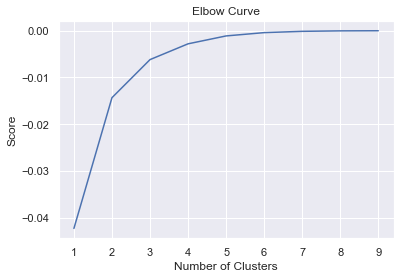

In [34]:
print(len(la_grouped[la_grouped["Bar"] > 0])) # print the number of bars scanned 
la_hot = la_grouped[["Neighborhoods","Bar"]]
K_clusters = range(1,10) # pass the number of clusters as the independent variable
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = la_hot[['Bar']]
X_axis = la_hot[['Neighborhoods']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show() 

## KMeans Clustering Method

In [35]:
kclusters = 3 # purely based on the elbow curve as above

la_clustering = la_hot.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_clustering)

la_merged = la_hot.copy()

# add clustering labels
la_merged["Cluster Labels"] = kmeans.labels_

la_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
la_merged.head(10)

,Neighborhood,Bar,Cluster Labels
0,East Los Angeles,0.00,1
1,Angeles Mesa,0.01,1
2,Angelino Heights,0.01,1
3,Angelus Vista,0.01,1
4,Arleta,0.00,1
5,Arlington Heights,0.00,1
6,Arts District,0.00,1
7,Atwater Village,0.01,1
8,Baldwin Hills,0.02,0
9,Baldwin Hills/Crenshaw,0.01,1


In [36]:
la_merged = la_merged.join(df.set_index("Neighborhood"), on="Neighborhood")

print(la_merged.shape)
la_merged.head() # check the last columns!

(201, 5)


,Neighborhood,Bar,Cluster Labels,Latitude,Longitude
0,East Los Angeles,0.00,1,34.033470,-118.159090
1,Angeles Mesa,0.01,1,32.764074,-116.986171
2,Angelino Heights,0.01,1,34.070290,-118.254800
3,Angelus Vista,0.01,1,34.087575,-118.267156
4,Arleta,0.00,1,34.249050,-118.433490


In [37]:
print(la_merged.shape)
la_merged.sort_values(["Bar"], inplace=True)
la_merged

(201, 5)


,Neighborhood,Bar,Cluster Labels,Latitude,Longitude
0,East Los Angeles,0.000000,1,34.033470,-118.159090
92,Lake Balboa,0.000000,1,34.207160,-118.501140
91,Lafayette Square,0.000000,1,34.043060,-118.331940
168,Valley Glen,0.000000,1,34.187110,-118.413810
86,Jefferson Park,0.000000,1,34.032640,-118.318020
85,Hyde Park,0.000000,1,33.989040,-118.326700
84,Holmby Hills,0.000000,1,34.052901,-118.423903
170,Van Nuys,0.000000,1,34.184390,-118.446520
171,Venice,0.000000,1,33.987540,-118.472150
172,Vermont Knolls,0.000000,1,34.092413,-118.291005


### Folium Map to visualize the clusters

In [38]:
# create a default map of LA 
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_merged['Latitude'], la_merged['Longitude'], la_merged['Neighborhood'], la_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [39]:
# create a map of LA using 'Stamen Terrain'
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='Stamen Terrain')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_merged['Latitude'], la_merged['Longitude'], la_merged['Neighborhood'], la_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters